In [33]:
# Magic Wand Gesture Classification - CNN 1D
#Model do rozpoznawania gestów magicznej różdżki na podstawie danych IMU (akcelerometr + żyroskop)

## 1. Import bibliotek

In [34]:
import numpy as np
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.20.0
Keras version: 3.13.0


## 2. Wczytanie danych

In [35]:
def load_gesture_data(folder_path, gesture_name):
    """
    Wczytuje wszystkie pliki CSV z danego folderu
    Zwraca listę sekwencji (każda sekwencja to macierz [timesteps, 6_features])
    """
    files = glob.glob(os.path.join(folder_path, '*.csv'))
    sequences = []
    
    for file in files:
        df = pd.read_csv(file)
        # Usuwamy kolumnę time, zostawiamy tylko 6 cech IMU
        # acc_X, acc_Y, acc_Z, gyro_X, gyro_Y, gyro_Z
        features = df[['acc_X', 'acc_Y', 'acc_Z', 'gyro_X', 'gyro_Y', 'gyro_Z']].values
        sequences.append(features)
    
    print(f"{gesture_name}: {len(sequences)} próbek")
    return sequences

# Wczytaj dane dla każdego gestu
alohomora_data = load_gesture_data('alohomora_new', 'Aromohola')
lumos_data = load_gesture_data('lumos_new', 'Luks')
wingardium_data = load_gesture_data('wingardium_new', 'Winger Linger')
avada_data = load_gesture_data('avada_new', 'Aveda')

Aromohola: 60 próbek
Luks: 60 próbek
Winger Linger: 60 próbek
Aveda: 60 próbek


## 3. Analiza długości sekwencji

In [36]:
# Sprawdź długości sekwencji
all_lengths = []
for data, name in [(alohomora_data, 'Aromohola'), 
                    (lumos_data, 'Luks'), 
                    (wingardium_data, 'Winger Linger'), 
                    (avada_data, 'Aveda')]:
    lengths = [len(seq) for seq in data]
    all_lengths.extend(lengths)
    print(f"{name}: min={min(lengths)}, max={max(lengths)}, avg={np.mean(lengths):.1f}")

print(f"\nWszystkie: min={min(all_lengths)}, max={max(all_lengths)}, avg={np.mean(all_lengths):.1f}")

MAX_SEQUENCE_LENGTH = 200

Aromohola: min=163, max=314, avg=239.6
Luks: min=93, max=328, avg=175.8
Winger Linger: min=135, max=278, avg=200.1
Aveda: min=127, max=313, avg=183.8

Wszystkie: min=93, max=328, avg=199.8


## 4. Preprocessing - padding i normalizacja

In [37]:
def pad_sequences(sequences, max_length):
    """
    Dopasowuje sekwencje do stałej długości
    - Jeśli za krótka: wypełnia zerami na końcu
    - Jeśli za długa: obcina do max_length
    """
    padded = []
    for seq in sequences:
        if len(seq) < max_length:
            # Padding zerami
            padding = np.zeros((max_length - len(seq), seq.shape[1]))
            padded_seq = np.vstack([seq, padding])
        else:
            # Obcinamy do max_length
            padded_seq = seq[:max_length]
        padded.append(padded_seq)
    return np.array(padded)

# Przygotowanie danych
X_alohomora = pad_sequences(alohomora_data, MAX_SEQUENCE_LENGTH)
X_lumos = pad_sequences(lumos_data, MAX_SEQUENCE_LENGTH)
X_wingardium = pad_sequences(wingardium_data, MAX_SEQUENCE_LENGTH)
X_avada = pad_sequences(avada_data, MAX_SEQUENCE_LENGTH)

# Łączymy wszystkie dane
X = np.vstack([X_alohomora, X_lumos, X_wingardium, X_avada])

# Etykiety (0: alohomora, 1: lumos, 2: wingardium, 3: avada)
y_alohomora = np.zeros(len(X_alohomora), dtype=int)
y_lumos = np.ones(len(X_lumos), dtype=int)
y_wingardium = np.full(len(X_wingardium), 2, dtype=int)
y_avada = np.full(len(X_avada), 3, dtype=int)

y = np.concatenate([y_alohomora, y_lumos, y_wingardium, y_avada])

print(f"Kształt danych X: {X.shape}")  # (total_samples, 100, 6)
print(f"Kształt etykiet y: {y.shape}")  # (total_samples,)
print(f"Rozkład klas: {np.bincount(y)}")

Kształt danych X: (240, 200, 6)
Kształt etykiet y: (240,)
Rozkład klas: [60 60 60 60]


## 5. Podział na zbiór treningowy i testowy

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Treningowy: {X_train.shape[0]} próbek")
print(f"Testowy: {X_test.shape[0]} próbek")

Treningowy: 192 próbek
Testowy: 48 próbek


## 6. Budowa modelu CNN 1D

In [39]:
def create_cnn_model(input_shape, num_classes):
    """
    CNN 1D zoptymalizowany dla microcontrollerów (Arduino Nano 33 BLE Sense)
    - Bardzo małe warstwy (aby zmieścić się w 1MB flash)
    - BatchNormalization dla stabilności
    - Dropout dla regularyzacji
    """
    model = keras.Sequential([
        # Pierwsza warstwa konwolucyjna (zmniejszono z 16 do 8)
        layers.Conv1D(8, kernel_size=5, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),
        
        # Druga warstwa konwolucyjna (zmniejszono z 32 do 16)
        layers.Conv1D(16, kernel_size=5, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),
        
        # Trzecia warstwa konwolucyjna (zmniejszono z 64 do 32)
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        
        # Flatten i warstwy gęste (zmniejszono rozmiary)
        layers.Flatten(),
        layers.Dense(32, activation='relu'),  # zmniejszono z 64 do 32
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),  # zmniejszono z 32 do 16
        layers.Dropout(0.2),
        
        # Warstwa wyjściowa
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Tworzenie modelu
model = create_cnn_model(input_shape=(MAX_SEQUENCE_LENGTH, 6), num_classes=4)
model.summary()

# Informacja o rozmiarze modelu
param_count = model.count_params()
print(f"\nLiczba parametrów: {param_count:,}")
print(f"Przybliżony rozmiar (float32): ~{param_count * 4 / 1024:.1f} KB")

s:\MagicWand\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 196, 8)         │           248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 196, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 98, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 98, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 94, 16)         │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 94, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 47, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 47, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 45, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 45, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 22, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 22, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,852 (100.98 KB)

 Trainable params: 25,740 (100.55 KB)

 Non-trainable params: 112 (448.00 B)


Liczba parametrów: 25,852
Przybliżony rozmiar (float32): ~101.0 KB


## 7. Kompilacja i trening

In [40]:
# Kompilacja
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

# Trening
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.2614 - loss: 2.2178 - val_accuracy: 0.3590 - val_loss: 1.5272 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4641 - loss: 1.3151 - val_accuracy: 0.4615 - val_loss: 1.1370 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5163 - loss: 1.1184 - val_accuracy: 0.5641 - val_loss: 0.9998 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5882 - loss: 0.9398 - val_accuracy: 0.5641 - val_loss: 0.9106 - learning_rate: 0.0010
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6275 - loss: 0.8633 - val_accuracy: 0.5897 - val_loss: 0.8471 - learning_rate: 0.0010
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6928 - loss: 0.7720 - val_accuracy: 0.5897 - val_loss: 0.7975 - learning_rate: 0.0010
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7516 - loss: 0.7120 - val_accuracy: 

## 8. Wizualizacja wyników treningu

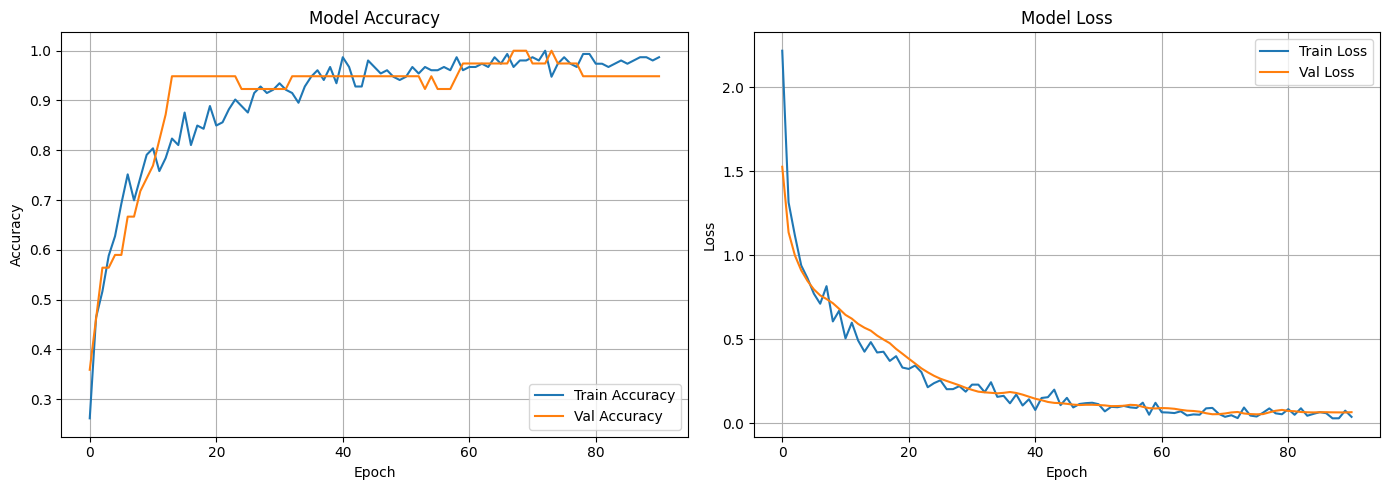

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 9. Ewaluacja na zbiorze testowym

In [42]:
# Predykcja na zbiorze testowym
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Dokładność
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Classification report
class_names = ['aromohola', 'luks', 'winger linger', 'aveda']
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/stepWARNING:tensorflow:6 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E34450D4E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0313

Test Accuracy: 1.0000
Test Loss: 0.0313

Classification Report:
               precision    recall  f1-score   support

    aromohola       1.00      1.00      1.00        12
         luks       1.00      1.00      1.00        12
winger linger       1.00      1.00      1.00        12
        aveda       1.00      1.00      1.00        12

     accuracy                           1.00        48
    macro avg       1.00      1.00      1.00        48
 weighted avg       1.00      1.00      1.00        48



## 10. Confusion Matrix

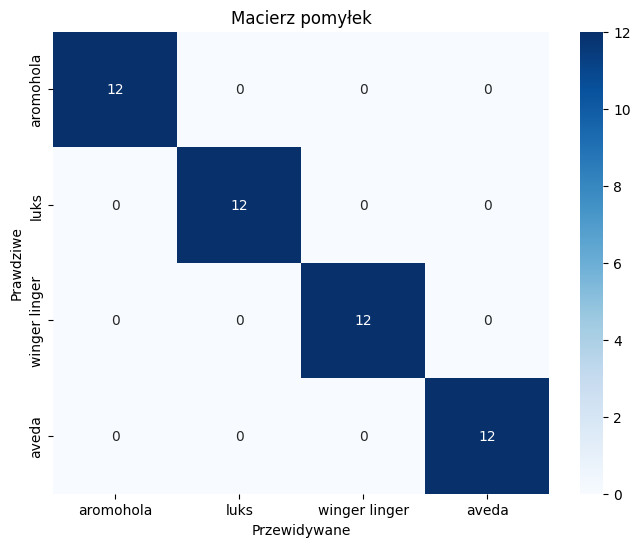

In [43]:
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Przewidywane')
plt.ylabel('Prawdziwe')
plt.title('Macierz pomyłek')
plt.show()

## 11. Zapis modelu

In [44]:
# Zapis modelu w formacie Keras (.h5)
model.save('gesture_model_cnn.h5')
print("Model zapisany jako gesture_model_cnn.h5")

# Zapis również w nowym formacie Keras 3 (.keras)
model.save('gesture_model_cnn.keras')
print("Model zapisany jako gesture_model_cnn.keras")

Model zapisany jako gesture_model_cnn.h5
Model zapisany jako gesture_model_cnn.keras


## 12. Konwersja do TensorFlow Lite (dla microcontrollerów)

In [ ]:
# Convert to TensorFlow Lite with INT8 quantization for Arduino
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# INT8 QUANTIZATION - drastically reduces model size (4x smaller)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Representative dataset function for quantization (training data samples)
def representative_dataset():
    for i in range(100):
        # Select a random sample from training data
        idx = np.random.randint(0, len(X_train))
        sample = X_train[idx:idx+1].astype(np.float32)
        yield [sample]

converter.representative_dataset = representative_dataset

# Force full INT8 quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Perform conversion
tflite_model_quant = converter.convert()

# Save the quantized model
with open('gesture_model_cnn.tflite', 'wb') as f:
    f.write(tflite_model_quant)

print(f"TFLite model (INT8 quantized) saved: {len(tflite_model_quant):,} bytes")
print(f"Size: {len(tflite_model_quant) / 1024:.1f} KB")
print(f"Model fits in Arduino Nano 33 BLE Sense (1MB flash): {'YES ✓' if len(tflite_model_quant) < 1024*1024 else 'NO ✗'}")

# Convert to C array (for Arduino)
def convert_to_c_array(tflite_model, output_file='model.h'):
    """Converts TFLite model to C array for Arduino"""
    
    c_str = '#ifndef MODEL_H\n'
    c_str += '#define MODEL_H\n\n'
    c_str += '// Model size: ' + str(len(tflite_model)) + ' bytes\n'
    c_str += '// Quantized to INT8 for Arduino Nano 33 BLE Sense\n\n'
    c_str += 'const unsigned char model_tflite[] = {\n  '
    
    hex_array = [f'0x{byte:02x}' for byte in tflite_model]
    
    # Format 12 elements per line
    for i, hex_val in enumerate(hex_array):
        c_str += hex_val
        if i < len(hex_array) - 1:
            c_str += ', '
        if (i + 1) % 12 == 0:
            c_str += '\n  '
    
    c_str += '\n};\n'
    c_str += f'const unsigned int model_tflite_len = {len(tflite_model)};\n\n'
    c_str += '#endif\n'
    
    with open(output_file, 'w') as f:
        f.write(c_str)
    
    print(f"C header saved as: {output_file}")

# Generate .h file for Arduino
convert_to_c_array(tflite_model_quant, 'gesture_model_cnn.h')

print("\n⚠️ IMPORTANT for Arduino:")
print("1. Model is quantized to INT8")
print("2. Input and output are INT8 type (not FLOAT32)")
print("3. You must scale input data before passing to model")
print("4. You must descale output results from model")


INFO:tensorflow:Assets written to: C:\Users\OlekPC\AppData\Local\Temp\tmpuy_51hl7\assets


INFO:tensorflow:Assets written to: C:\Users\OlekPC\AppData\Local\Temp\tmpuy_51hl7\assets


Saved artifact at 'C:\Users\OlekPC\AppData\Local\Temp\tmpuy_51hl7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 6), dtype=tf.float32, name='keras_tensor_60')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2075336713296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2075336709840: TensorSpec(shape=(), dtype=tf.resource, name=None)


s:\MagicWand\.venv\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


RuntimeError: Attempting to resize dimension 1 of tensor 0 with value 100 to 200. ResizeInputTensorStrict only allows mutating unknown dimensions identified by -1.

## 13. Test pojedynczej predykcji

In [46]:
# Test na przykładowej próbce
sample_idx = 0
sample = X_test[sample_idx:sample_idx+1]
true_label = y_test[sample_idx]
print(sample)
prediction = model.predict(sample, verbose=0)
predicted_class = np.argmax(prediction)
confidence = prediction[0][predicted_class]

print(f"Prawdziwa klasa: {class_names[true_label]}")
print(f"Przewidziana klasa: {class_names[predicted_class]}")
print(f"Pewność: {confidence:.2%}")
print(f"\nWszystkie prawdopodobieństwa:")
for i, prob in enumerate(prediction[0]):
    print(f"  {class_names[i]}: {prob:.2%}")

[[[ 2.2000e-01  4.7000e-01 -8.5000e-01 -2.1360e+01 -2.5020e+01
    4.1990e+01]
  [ 3.4000e-01  5.3000e-01 -5.4000e-01 -2.1420e+01 -2.4110e+01
    4.4070e+01]
  [ 3.0000e-01  5.3000e-01 -5.9000e-01 -2.0200e+01 -3.5890e+01
    4.2240e+01]
  ...
  [ 1.7000e-01  4.8000e-01 -5.3000e-01  7.5740e+01 -1.2836e+02
   -4.3820e+01]
  [ 1.1000e-01  4.9000e-01 -5.5000e-01  7.3180e+01 -1.3654e+02
   -4.7060e+01]
  [ 3.0000e-02  4.8000e-01 -5.6000e-01  6.8600e+01 -1.4722e+02
   -5.0050e+01]]]
Prawdziwa klasa: aromohola
Przewidziana klasa: aromohola
Pewność: 100.00%

Wszystkie prawdopodobieństwa:
  aromohola: 100.00%
  luks: 0.00%
  winger linger: 0.00%
  aveda: 0.00%


# WIP

## 14. Inspekcja operacji w modelu TFLite

In [47]:
import tensorflow as tf

# Załaduj model
interpreter = tf.lite.Interpreter(model_path="gesture_model_cnn.tflite")
interpreter.allocate_tensors()

# Pobierz wszystkie operacje
ops = set()
for detail in interpreter.get_tensor_details():
    ops.add(detail['name'])

# Wyświetl unikalne operacje
print("Operacje w modelu:")
for op in sorted(ops):
    print(op)

Operacje w modelu:
StatefulPartitionedCall_1:0
arith.constant
arith.constant1
arith.constant10
arith.constant2
arith.constant3
arith.constant4
arith.constant5
arith.constant6
arith.constant7
arith.constant8
arith.constant9
sequential_3_1/batch_normalization_6_1/batchnorm/add_1;sequential_3_1/conv1d_6_1/convolution/Squeeze;sequential_3_1/batch_normalization_6_1/batchnorm/mul_1;sequential_3_1/conv1d_6_1/Relu;sequential_3_1/conv1d_6_1/BiasAdd;
sequential_3_1/batch_normalization_6_1/batchnorm/add_1;sequential_3_1/conv1d_6_1/convolution/Squeeze;sequential_3_1/batch_normalization_6_1/batchnorm/mul_1;sequential_3_1/conv1d_6_1/Relu;sequential_3_1/conv1d_6_1/BiasAdd;1
sequential_3_1/batch_normalization_6_1/batchnorm/mul_1;sequential_3_1/conv1d_6_1/convolution/Squeeze;sequential_3_1/conv1d_6_1/Relu;sequential_3_1/conv1d_6_1/BiasAdd;
sequential_3_1/batch_normalization_7_1/batchnorm/add_1;sequential_3_1/conv1d_7_1/convolution/Squeeze;sequential_3_1/batch_normalization_7_1/batchnorm/mul_1;sequentia

s:\MagicWand\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [48]:
# Załaduj model TFLite
interpreter = tf.lite.Interpreter(model_path="gesture_model_cnn.tflite")
interpreter.allocate_tensors()

# Pobierz wszystkie tensory
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
tensor_details = interpreter.get_tensor_details()

print("=== ANALIZA PAMIĘCI DLA ARDUINO ===\n")

# Rozmiar wejścia
input_size = np.prod(input_details[0]['shape'])
print(f"Input tensor size: {input_size} elementów")
print(f"Input shape: {input_details[0]['shape']}")
print(f"Input type: {input_details[0]['dtype']}")

# Rozmiar wyjścia
output_size = np.prod(output_details[0]['shape'])
print(f"\nOutput tensor size: {output_size} elementów")
print(f"Output shape: {output_details[0]['shape']}")
print(f"Output type: {output_details[0]['dtype']}")

# Suma wszystkich tensorów (przybliżona arena size)
total_tensor_size = 0
print("\n=== WSZYSTKIE TENSORY ===")
for i, detail in enumerate(tensor_details):
    tensor_size = np.prod(detail['shape']) if len(detail['shape']) > 0 else 0
    # INT8 = 1 bajt, FLOAT32 = 4 bajty
    if detail['dtype'] == np.int8:
        bytes_size = tensor_size * 1
    elif detail['dtype'] == np.float32:
        bytes_size = tensor_size * 4
    else:
        bytes_size = tensor_size * 2  # INT16/UINT16
    
    total_tensor_size += bytes_size
    if i < 10:  # Pokaż pierwsze 10
        print(f"{i}: {detail['name'][:50]:50s} Shape: {str(detail['shape']):20s} Size: {bytes_size:6d} B")

print(f"\n... (total {len(tensor_details)} tensors)")

# Rekomendowane rozmiary arena
recommended_min = total_tensor_size
recommended_safe = int(total_tensor_size * 1.5)  # +50% buffer
recommended_max = int(total_tensor_size * 2.0)   # +100% buffer

print(f"\n=== REKOMENDOWANE TENSOR ARENA SIZE ===")
print(f"Minimalna (suma tensorów):     {recommended_min:,} bajtów ({recommended_min/1024:.1f} KB)")
print(f"Bezpieczna (+50% buffer):      {recommended_safe:,} bajtów ({recommended_safe/1024:.1f} KB)")
print(f"Maksymalna (+100% buffer):     {recommended_max:,} bajtów ({recommended_max/1024:.1f} KB)")

print(f"\n=== ARDUINO NANO 33 BLE SENSE REV2 ===")
print(f"Dostępna SRAM: 256 KB (262,144 bajtów)")
print(f"Rozmiar modelu (flash): {len(tflite_model_quant)/1024:.1f} KB")
print(f"SRAM dla tensor arena: ~200 KB (po odjęciu stack, zmienne, bufory)")

# Zaokrąglij do wielokrotności 1024
arena_rounded = ((recommended_safe // 1024) + 1) * 1024

print(f"\n{'='*60}")
print(f"✓ UŻYJ W ARDUINO:")
print(f"{'='*60}")
print(f"constexpr int kTensorArenaSize = {arena_rounded};")
print(f"// czyli {arena_rounded/1024:.0f} KB")
print(f"{'='*60}")

# Sprawdź czy zmieści się w SRAM
if arena_rounded < 200 * 1024:
    print(f"\n✓ Model zmieści się w SRAM Arduino! ({arena_rounded/1024:.0f} KB < 200 KB)")
else:
    print(f"\n✗ UWAGA: Model może być za duży dla SRAM! ({arena_rounded/1024:.0f} KB > 200 KB)")
    print("   Rozważ dalsze zmniejszenie modelu (mniej filtrów/warstw)")
    
print("\nUWAGA: Jeśli w Arduino wystąpi błąd 'AllocateTensors() failed',")
print("       zwiększ kTensorArenaSize o 10-20 KB i spróbuj ponownie.")

=== ANALIZA PAMIĘCI DLA ARDUINO ===

Input tensor size: 1200 elementów
Input shape: [  1 200   6]
Input type: <class 'numpy.int8'>

Output tensor size: 4 elementów
Output shape: [1 4]
Output type: <class 'numpy.int8'>

=== WSZYSTKIE TENSORY ===
0: serving_default_keras_tensor_41:0                  Shape: [  1 200   6]        Size:   1200 B
1: arith.constant                                     Shape: []                   Size:      0 B
2: arith.constant1                                    Shape: [3]                  Size:      6 B
3: arith.constant2                                    Shape: []                   Size:      0 B
4: arith.constant3                                    Shape: [3]                  Size:      6 B
5: arith.constant4                                    Shape: [3]                  Size:      6 B
6: arith.constant5                                    Shape: [3]                  Size:      6 B
7: arith.constant6                                    Shape: [3]            

In [49]:
import tensorflow as tf
import numpy as np

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(100, 6)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Kwantyzuj
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Zapisz
with open('gesture_model_int8.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\OlekPC\AppData\Local\Temp\tmpzneurogu\assets


s:\MagicWand\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
INFO:tensorflow:Assets written to: C:\Users\OlekPC\AppData\Local\Temp\tmpzneurogu\assets


Saved artifact at 'C:\Users\OlekPC\AppData\Local\Temp\tmpzneurogu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 6), dtype=tf.float32, name='keras_tensor_60')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2075336713296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2075336709840: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [50]:
import tensorflow as tf
import numpy as np

# Załaduj model
model = tf.keras.models.load_model('twoj_model.h5')

# KLUCZOWE: Representative dataset dla INT8 quantization
def representative_dataset():
    # Użyj prawdziwych danych treningowych lub przykładowych
    for _ in range(100):
        # Przykładowe dane - ZASTĄP swoimi prawdziwymi danymi treningowymi!
        data = np.random.uniform(-10, 10, (1, 100, 6)).astype(np.float32)
        yield [data]

# Konwersja z FULL INT8 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # WAŻNE!
converter.inference_output_type = tf.int8  # WAŻNE!

# Konwertuj
tflite_model = converter.convert()

# Zapisz
with open('gesture_model_int8.tflite', 'wb') as f:
    f.write(tflite_model)

# Konwertuj do C array
import binascii
with open('gesture_model_int8.tflite', 'rb') as f:
    tflite_binary = f.read()

hex_array = ', '.join([f'0x{b:02x}' for b in tflite_binary])

with open('gesture_model_cnn.h', 'w') as f:
    f.write(f'const unsigned int model_tflite_len = {len(tflite_binary)};\n')
    f.write(f'const unsigned char model_tflite[] = {{\n  ')
    f.write(hex_array)
    f.write('\n};\n')

print(f"Model size: {len(tflite_binary)} bytes")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'twoj_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
import tensorflow as tf
import numpy as np

# Załaduj model TFLite
interpreter = tf.lite.Interpreter(model_path="gesture_model_cnn.tflite")
interpreter.allocate_tensors()

# Pobierz szczegóły input/output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("="*70)
print("WERYFIKACJA KWANTYZACJI MODELU gesture_model_cnn.tflite")
print("="*70)

print("\n### INPUT TENSOR ###")
print(f"Name: {input_details[0]['name']}")
print(f"Shape: {input_details[0]['shape']}")
print(f"Type: {input_details[0]['dtype']}")
print(f"Quantization: {input_details[0]['quantization']}")
print(f"Quantization parameters: {input_details[0]['quantization_parameters']}")

if input_details[0]['dtype'] == np.int8:
    print("✓ INPUT jest INT8 (model skwantyzowany)")
    print(f"  Scale: {input_details[0]['quantization_parameters']['scales'][0]}")
    print(f"  Zero point: {input_details[0]['quantization_parameters']['zero_points'][0]}")
elif input_details[0]['dtype'] == np.float32:
    print("✗ INPUT jest FLOAT32 (model NIE jest skwantyzowany!)")
else:
    print(f"? INPUT jest typu {input_details[0]['dtype']}")

print("\n### OUTPUT TENSOR ###")
print(f"Name: {output_details[0]['name']}")
print(f"Shape: {output_details[0]['shape']}")
print(f"Type: {output_details[0]['dtype']}")
print(f"Quantization: {output_details[0]['quantization']}")
print(f"Quantization parameters: {output_details[0]['quantization_parameters']}")

if output_details[0]['dtype'] == np.int8:
    print("✓ OUTPUT jest INT8 (model skwantyzowany)")
    print(f"  Scale: {output_details[0]['quantization_parameters']['scales'][0]}")
    print(f"  Zero point: {output_details[0]['quantization_parameters']['zero_points'][0]}")
elif output_details[0]['dtype'] == np.float32:
    print("✗ OUTPUT jest FLOAT32 (model NIE jest skwantyzowany!)")
else:
    print(f"? OUTPUT jest typu {output_details[0]['dtype']}")

print("\n### WSZYSTKIE OPERACJE W MODELU ###")
tensor_details = interpreter.get_tensor_details()
op_types = set()
for detail in tensor_details:
    if 'name' in detail:
        # Extract op type from tensor name if possible
        name = detail['name']
        if ';' in name:
            op_type = name.split(';')[0]
            op_types.add(op_type)

print(f"Liczba tensorów: {len(tensor_details)}")
print("\nTypy operacji:")
for op in sorted(op_types):
    print(f"  - {op}")

print("\n### ROZMIAR MODELU ###")
import os
model_size = os.path.getsize("gesture_model_cnn.tflite")
print(f"Rozmiar pliku: {model_size:,} bajtów ({model_size/1024:.2f} KB)")

print("\n### ANALIZA TENSORÓW WEWNĘTRZNYCH ###")
int8_count = 0
float32_count = 0
other_count = 0

for detail in tensor_details:
    if detail['dtype'] == np.int8:
        int8_count += 1
    elif detail['dtype'] == np.float32:
        float32_count += 1
    else:
        other_count += 1

print(f"Tensory INT8: {int8_count}")
print(f"Tensory FLOAT32: {float32_count}")
print(f"Tensory inne: {other_count}")

if float32_count > 0:
    print("\n⚠️ UWAGA: Model zawiera tensory FLOAT32!")
    print("   Model może nie być w pełni skwantyzowany do INT8.")
    print("   Należy przekonwertować model ponownie z pełną kwantyzacją.")
else:
    print("\n✓ Model jest w pełni skwantyzowany do INT8")

print("\n" + "="*70)
print("WNIOSEK:")
if input_details[0]['dtype'] == np.int8 and output_details[0]['dtype'] == np.int8 and float32_count == 0:
    print("✓✓✓ Model jest POPRAWNIE skwantyzowany do INT8")
    print("     Plik gesture_model_cnn.h powinien działać na Arduino")
else:
    print("✗✗✗ Model NIE jest poprawnie skwantyzowany!")
    print("     Należy przekonwertować model ponownie z pełną kwantyzacją INT8")
print("="*70)

WERYFIKACJA KWANTYZACJI MODELU gesture_model_cnn.tflite

### INPUT TENSOR ###
Name: serving_default_keras_tensor:0
Shape: [  1 100   6]
Type: <class 'numpy.int8'>
Quantization: (4.328470706939697, -21)
Quantization parameters: {'scales': array([4.3284707], dtype=float32), 'zero_points': array([-21], dtype=int32), 'quantized_dimension': 0}
✓ INPUT jest INT8 (model skwantyzowany)
  Scale: 4.328470706939697
  Zero point: -21

### OUTPUT TENSOR ###
Name: StatefulPartitionedCall_1:0
Shape: [1 4]
Type: <class 'numpy.int8'>
Quantization: (0.00390625, -128)
Quantization parameters: {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}
✓ OUTPUT jest INT8 (model skwantyzowany)
  Scale: 0.00390625
  Zero point: -128

### WSZYSTKIE OPERACJE W MODELU ###
Liczba tensorów: 62

Typy operacji:
  - sequential_1/batch_normalization_1/batchnorm/add_1
  - sequential_1/batch_normalization_1/batchnorm/mul_1
  - sequential_1/batch_normalization_1_2

In [ ]:
import tensorflow as tf
import numpy as np

# Załaduj model TFLite
interpreter = tf.lite.Interpreter(model_path="gesture_model_cnn.tflite")
interpreter.allocate_tensors()

# Pobierz wszystkie tensory
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
tensor_details = interpreter.get_tensor_details()

print("="*70)
print("OBLICZENIE TENSOR ARENA SIZE DLA ARDUINO")
print("="*70)

# Analiza rozmiarów tensorów
total_size = 0
max_tensor_size = 0

print("\nTop 10 największych tensorów:")
tensor_sizes = []
for detail in tensor_details:
    if len(detail['shape']) > 0:
        size = np.prod(detail['shape'])
        if detail['dtype'] == np.int8:
            bytes_size = size * 1
        elif detail['dtype'] == np.float32:
            bytes_size = size * 4
        elif detail['dtype'] == np.int32:
            bytes_size = size * 4
        else:
            bytes_size = size * 2
        
        tensor_sizes.append((detail['name'], bytes_size, detail['shape'], detail['dtype']))
        total_size += bytes_size
        max_tensor_size = max(max_tensor_size, bytes_size)

# Sortuj i pokaż największe
tensor_sizes.sort(key=lambda x: x[1], reverse=True)
for i, (name, size, shape, dtype) in enumerate(tensor_sizes[:10]):
    print(f"{i+1:2d}. {name[:50]:50s} {size:6d} B  {str(shape):20s}")

print(f"\nSuma wszystkich tensorów: {total_size:,} bajtów ({total_size/1024:.2f} KB)")
print(f"Największy tensor: {max_tensor_size:,} bajtów ({max_tensor_size/1024:.2f} KB)")

# Rekomendowane rozmiary (TFLite potrzebuje buffer dla operations)
recommended_min = total_size
recommended_safe = int(total_size * 2.0)   # 2x dla pewności
recommended_max = int(total_size * 3.0)    # 3x dla maksymalnej pewności

print(f"\n{'='*70}")
print("REKOMENDOWANE TENSOR ARENA SIZE:")
print(f"{'='*70}")
print(f"Minimum (suma tensorów):       {recommended_min:6,} B ({recommended_min/1024:5.1f} KB)")
print(f"Zalecane (2x buffer):         {recommended_safe:6,} B ({recommended_safe/1024:5.1f} KB)")
print(f"Maksymum (3x buffer):         {recommended_max:6,} B ({recommended_max/1024:5.1f} KB)")

# Zaokrąglij do wielokrotności 1024
arena_1x = ((recommended_min // 1024) + 1) * 1024
arena_2x = ((recommended_safe // 1024) + 1) * 1024
arena_3x = ((recommended_max // 1024) + 1) * 1024

print(f"\n{'='*70}")
print("WARTOŚCI DO UŻYCIA W ARDUINO:")
print(f"{'='*70}")
print(f"Opcja 1 (minimalna - może nie wystarczyć):")
print(f"  #define TENSOR_ARENA_SIZE {arena_1x:,}  // {arena_1x//1024} KB")
print(f"\nOpcja 2 (zalecana - bezpieczna): ⭐")
print(f"  #define TENSOR_ARENA_SIZE {arena_2x:,}  // {arena_2x//1024} KB")
print(f"\nOpcja 3 (maksymalna - najbezpieczniejsza):")
print(f"  #define TENSOR_ARENA_SIZE {arena_3x:,}  // {arena_3x//1024} KB")

print(f"\n{'='*70}")
print("ARDUINO NANO 33 BLE SENSE - Dostępna pamięć:")
print(f"{'='*70}")
print(f"Flash (program): 1 MB")
print(f"SRAM (runtime): 256 KB")
print(f"Model size: {len(tflite_model_quant)/1024:.1f} KB (w flash)")
print(f"Arena dla tensorów: {arena_2x/1024:.0f} KB (w SRAM)")
print(f"Pozostała SRAM: ~{256 - arena_2x/1024:.0f} KB (dla stack, zmienne, BLE, itd.)")

if arena_2x < 200 * 1024:
    print(f"\n✓ Arena {arena_2x//1024} KB zmieści się w SRAM (<200 KB)")
else:
    print(f"\n✗ UWAGA: Arena {arena_2x//1024} KB może być za duża dla SRAM!")
    print("  Rozważ zmniejszenie modelu lub wyłączenie BLE")

OBLICZENIE TENSOR ARENA SIZE DLA ARDUINO

Top 10 największych tensorów:
 1. tfl.pseudo_qconst5                                  10240 B  [ 32 320]           
 2. tfl.pseudo_qconst9                                   1536 B  [32  1  3 16]       
 3. sequential_1/conv1d_1/Relu;sequential_1/conv1d_1/B    768 B  [ 1  1 96  8]       
 4. sequential_1/batch_normalization_1/batchnorm/mul_1    768 B  [ 1  1 96  8]       
 5. sequential_1/batch_normalization_1/batchnorm/add_1    768 B  [ 1  1 96  8]       
 6. sequential_1/batch_normalization_1/batchnorm/add_1    768 B  [ 1 96  8]          
 7. sequential_1/max_pooling1d_1/MaxPool1d/ExpandDims     768 B  [ 1  1 96  8]       
 8. sequential_1/conv1d_1_2/Relu;sequential_1/conv1d_1    704 B  [ 1  1 44 16]       
 9. sequential_1/batch_normalization_1_2/batchnorm/mul    704 B  [ 1  1 44 16]       
10. sequential_1/batch_normalization_1_2/batchnorm/add    704 B  [ 1  1 44 16]       

Suma wszystkich tensorów: 28,860 bajtów (28.18 KB)
Największy tenso